<a href="https://colab.research.google.com/github/Blaze10/DL/blob/main/regularization%20/L1_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from torch.utils.data import DataLoader

In [2]:
iris = sns.load_dataset('iris')

In [3]:
data = torch.tensor(iris[iris.columns[:4]].values).float()
labels = torch.zeros(len(data), dtype=torch.long)

In [4]:
iris.species.value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

In [5]:
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

In [7]:
def create_model():
  ANNiris = nn.Sequential(
      nn.Linear(4,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,3)
  )

  loss_fun = nn.CrossEntropyLoss()
  optim = torch.optim.SGD(ANNiris.parameters(), lr=0.005)

  return ANNiris, loss_fun, optim

In [9]:
tmpmodel = create_model()[0]
print(tmpmodel)

for i in tmpmodel.named_parameters():
  print(i[0], i[1].shape, i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


## Function that trains the model

In [10]:
num_epochs = 1000

def train_model(L1lambda):
  train_acc = []
  test_acc = []
  losses = []

  # count the total number of weights in the model
  nweights = 0
  for pname, weight in ANNiris.named_parameters():
    if 'bias' not in pname:
      nweights = nweights + weight.numel()

  # loop over epochs
  for epochi in range(num_epochs):
    batch_acc = []
    batch_loss = []

    for X,y in train_loader:
      yHat = ANNiris(X)
      loss = loss_fun(yHat,y)

      # add L1 term
      L1_term = torch.tensor(0., requires_grad=True)
      for pname, weight in ANNiris.named_parameters():
        if 'bias' not in pname:
          L1_term = L1_term + torch.sum(torch.abs(weight))

      loss = loss * L1lambda / nweights

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batch_acc.append(100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item())
      batch_loss.append(loss.item())

    train_acc.append(np.mean(batch_acc))
    losses.append(np.mean(batch_loss))

    # test accuracy
    X,y = next(iter(test_loader))
    predlabels = torch.argmax(ANNiris(X), axis=1)
    test_acc.append(100 * torch.mean((predlabels == y).float()).item())


  return train_acc, test_acc, losses


In [11]:
ANNiris, loss_fun, optimizer = create_model()
L1lambda = .001
train_acc, test_acc, losses = train_model(L1lambda)

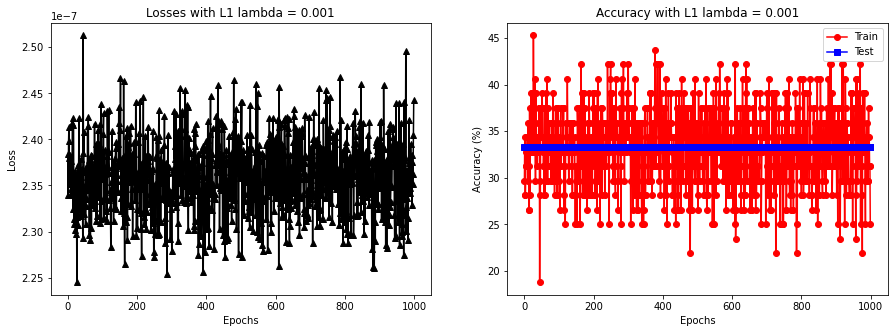

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(losses, 'k^-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title(f'Losses with L1 lambda = {L1lambda}')

ax[1].plot(train_acc, 'ro-')
ax[1].plot(test_acc, 'bs-')
ax[1].set_title(f'Accuracy with L1 lambda = {L1lambda}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train', 'Test'])
plt.show()

In [13]:
## Create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x, np.ones(k)/k, mode='same')

## Experiments

In [19]:
L1lambda = np.linspace(0,.005, 10)

# initialize the output results matrices
accuracy_results_train = np.zeros((num_epochs, len(L1lambda)))
accuracy_results_test = np.zeros((num_epochs, len(L1lambda)))

for li in range(len(L1lambda)):
  ANNiris, loss_fun, optimizer = create_model()
  train_acc, test_acc, losses = train_model(L1lambda[li])

  accuracy_results_train[:,li] = smooth(train_acc, 10)
  accuracy_results_test[:,li] = smooth(test_acc, 10)

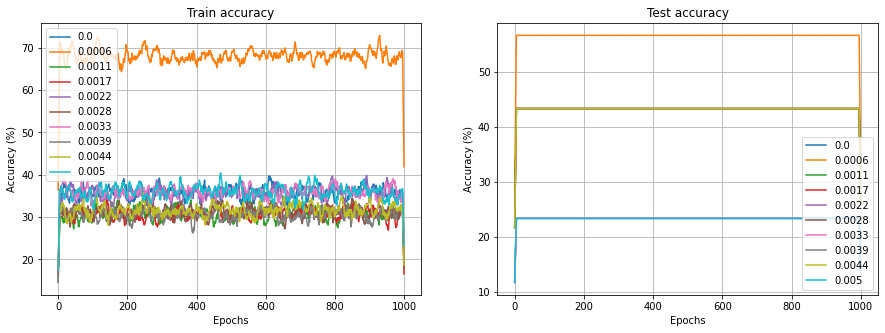

In [20]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(accuracy_results_train)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracy_results_test)
ax[1].set_title('Test accuracy')

# making the legend easier to read
leglabels = [np.round(i,4) for i in L1lambda]

for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('Accuracy (%)')
  # ax[i].set_ylim([50, 101])
  ax[i].grid()

plt.show()

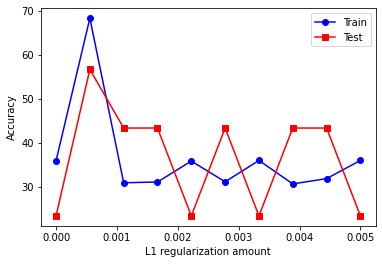

In [21]:
# show average accuracy by L1 rate
# average only some epochs
epoch_range = [500, 950]

plt.plot(L1lambda, np.mean(accuracy_results_train[epoch_range[0]: epoch_range[1], :], axis=0), 'bo-', label='Train')
plt.plot(L1lambda, np.mean(accuracy_results_test[epoch_range[0]: epoch_range[1], :], axis=0), 'rs-', label='Test')
plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()